In [1]:
from pathlib import Path

import pandas as pd


data_dir = Path("Data")
csv_files = sorted(data_dir.glob("parking_sessions_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSVs found at: {data_dir.resolve()}/parking_sessions_*.csv")

dfs = [
    pd.read_csv(
        f,
        na_values=["\\N"],
        keep_default_na=True,
    )
    for f in csv_files
]

dataframe_1 = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(csv_files)} CSV file(s) from {data_dir}/")
print(f"dataframe_1 shape: {dataframe_1.shape}")

Loaded 13 CSV file(s) from Data/
dataframe_1 shape: (587762, 15)


In [2]:
print("Using local CSVs in Data.")

Using local CSVs in Data.


## Exploratory Data Analysis (Python)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = dataframe_1
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")

Shape: (587762, 15)

Columns: ['SESSION_ID', 'LICENSE_PLATE', 'FACILITY_ID', 'FACILITY_NAME', 'DISTRICT', 'IN_TIME', 'OUT_TIME', 'ACTUAL_DURATION_HOURS', 'RATE_PER_HOUR', 'COST', 'STATUS', 'LICENSE_PLATE_STATE', 'INGESTED_AT', 'ROW_TIMESTAMP', 'OFFSET_ID']

Data Types:
SESSION_ID                object
LICENSE_PLATE             object
FACILITY_ID                int64
FACILITY_NAME             object
DISTRICT                  object
IN_TIME                   object
OUT_TIME                  object
ACTUAL_DURATION_HOURS    float64
RATE_PER_HOUR              int64
COST                     float64
STATUS                    object
LICENSE_PLATE_STATE       object
INGESTED_AT               object
ROW_TIMESTAMP             object
OFFSET_ID                 object
dtype: object


## Data Cleaning

In [4]:
print(f"Records before cleaning: {len(df)}")
df = df.dropna(subset=['OUT_TIME'])
print(f"Records after removing null OUT_TIME: {len(df)}")

Records before cleaning: 587762
Records after removing null OUT_TIME: 587762


In [5]:
df = df.drop(columns=['ROW_TIMESTAMP', 'OFFSET_ID'])
print(f"Columns after removal: {df.columns.tolist()}")

Columns after removal: ['SESSION_ID', 'LICENSE_PLATE', 'FACILITY_ID', 'FACILITY_NAME', 'DISTRICT', 'IN_TIME', 'OUT_TIME', 'ACTUAL_DURATION_HOURS', 'RATE_PER_HOUR', 'COST', 'STATUS', 'LICENSE_PLATE_STATE', 'INGESTED_AT']


In [6]:
df.describe(include='all')

,SESSION_ID,LICENSE_PLATE,FACILITY_ID,FACILITY_NAME,DISTRICT,IN_TIME,OUT_TIME,ACTUAL_DURATION_HOURS,RATE_PER_HOUR,COST,STATUS,LICENSE_PLATE_STATE,INGESTED_AT
count,587762,587762,587762.000000,587762,587762,587762,587762,587762.000000,587762.000000,587762.000000,587762,587762,587762
unique,587762,586715,NaN,50,6,578821,587760,NaN,NaN,NaN,1,21,395
top,f1b8c9a6-b171-408a-8f29-ecfb9376496f,EMM-1954,NaN,Yankee Stadium Lot A,Manhattan,2025-01-28 09:58:54.000 -0500,2025-04-01 13:55:59.231 -0400,NaN,NaN,NaN,completed,NY,2026-02-07 17:47:17.381 -0500
freq,1,3,NaN,48134,151077,3,2,NaN,NaN,NaN,587762,352590,2057
mean,NaN,NaN,26.481202,NaN,NaN,NaN,NaN,12.274569,15.326527,150.896504,NaN,NaN,NaN
std,NaN,NaN,14.584309,NaN,NaN,NaN,NaN,28.082342,11.348585,346.917394,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.250000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,3.070000,6.000000,25.790001,NaN,NaN,NaN
50%,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,4.490000,9.000000,51.820000,NaN,NaN,NaN
75%,NaN,NaN,37.000000,NaN,NaN,NaN,NaN,6.570000,25.000000,118.019997,NaN,NaN,NaN


In [8]:
missing = df.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    plt.figure(figsize=(10, 5))
    missing.plot(kind='bar', color='coral')
    plt.xlabel('Column')
    plt.ylabel('Missing Count')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values!')

No missing values!


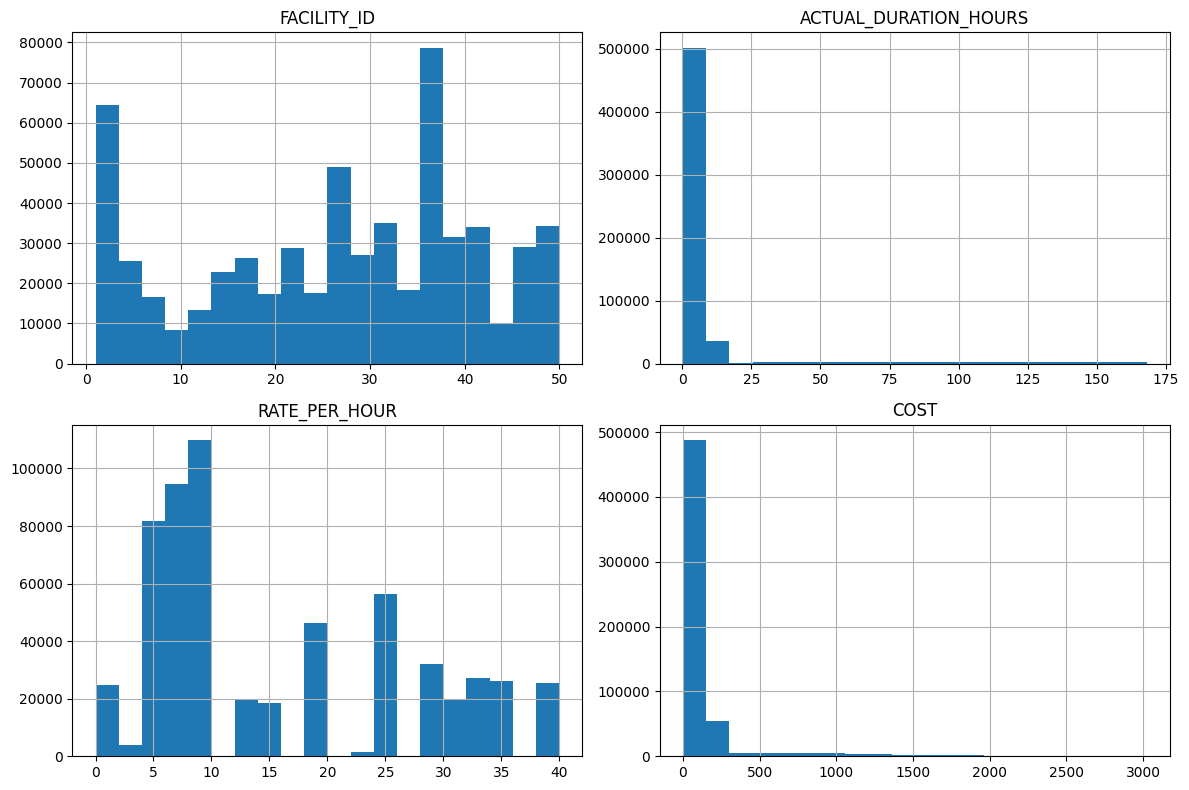

In [9]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if numeric_cols:
    df[numeric_cols].hist(figsize=(12, 8), bins=20)
    plt.tight_layout()
    plt.show()

## Parking Occupancy Analysis

In [10]:
# CSV values include offsets (e.g. -0500 / -0400). Parse in UTC, then normalize to one timezone.
df['IN_TIME'] = (
    pd.to_datetime(df['IN_TIME'], utc=True)
    .dt.tz_convert('America/New_York')
    .dt.tz_localize(None)
)
df['OUT_TIME'] = (
    pd.to_datetime(df['OUT_TIME'], utc=True)
    .dt.tz_convert('America/New_York')
    .dt.tz_localize(None)
)

events = pd.concat([
    df[['IN_TIME']].rename(columns={'IN_TIME': 'time'}).assign(change=1),
    df[['OUT_TIME']].rename(columns={'OUT_TIME': 'time'}).assign(change=-1)
]).sort_values('time')

events['occupancy'] = events['change'].cumsum()
print(f"Peak occupancy: {events['occupancy'].max()} cars")

Peak occupancy: 3009 cars


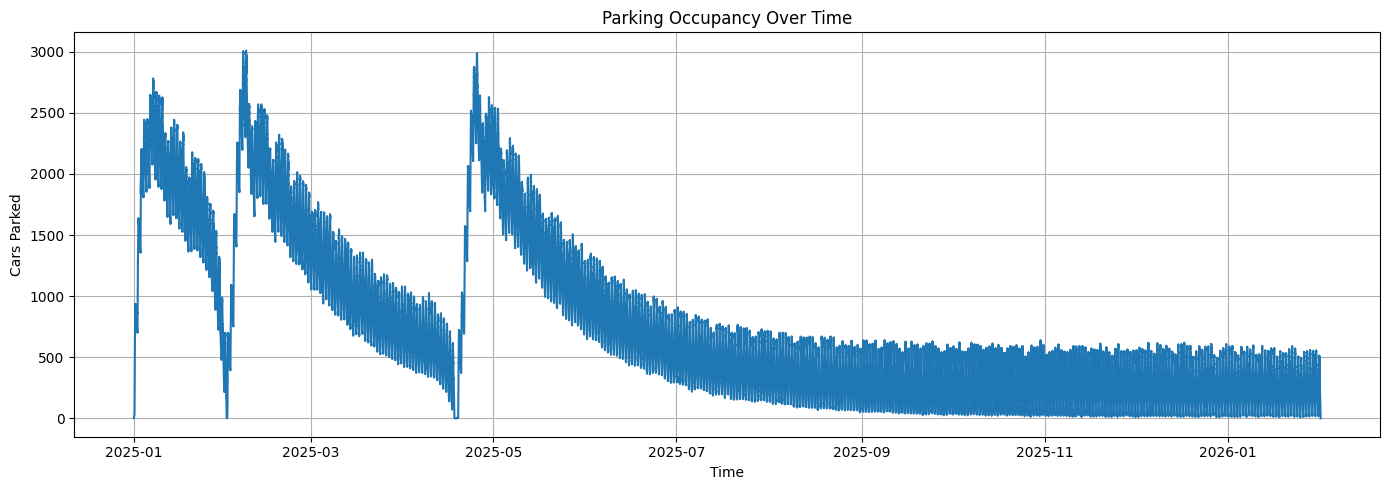

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(events['time'], events['occupancy'])
plt.xlabel('Time')
plt.ylabel('Cars Parked')
plt.title('Parking Occupancy Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

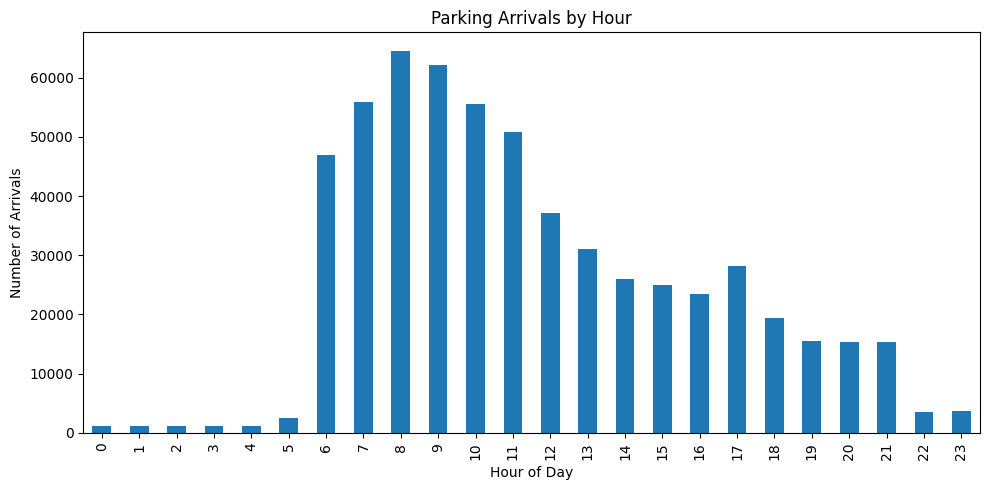

In [12]:
df['hour'] = df['IN_TIME'].dt.hour
hourly_arrivals = df.groupby('hour').size()

plt.figure(figsize=(10, 5))
hourly_arrivals.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Arrivals')
plt.title('Parking Arrivals by Hour')
plt.tight_layout()
plt.show()

## Linear Regression Models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Model 1: Predict Parking Duration

In [14]:
df['duration_minutes'] = (df['OUT_TIME'] - df['IN_TIME']).dt.total_seconds() / 60
df['arrival_hour'] = df['IN_TIME'].dt.hour
df['day_of_week'] = df['IN_TIME'].dt.dayofweek
df['month'] = df['IN_TIME'].dt.month

X_duration = df[['arrival_hour', 'day_of_week', 'month']]
y_duration = df['duration_minutes']

X_train, X_test, y_train, y_test = train_test_split(X_duration, y_duration, test_size=0.2, random_state=42)

model_duration = LinearRegression()
model_duration.fit(X_train, y_train)
y_pred = model_duration.predict(X_test)

print("=== Duration Prediction Model ===")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} minutes")
print(f"\nFeature Coefficients:")
for feat, coef in zip(X_duration.columns, model_duration.coef_):
    print(f"  {feat}: {coef:.4f}")

=== Duration Prediction Model ===
R² Score: 0.0575
RMSE: 1637.70 minutes

Feature Coefficients:
  arrival_hour: -54.4201
  day_of_week: -14.5772
  month: -88.9642


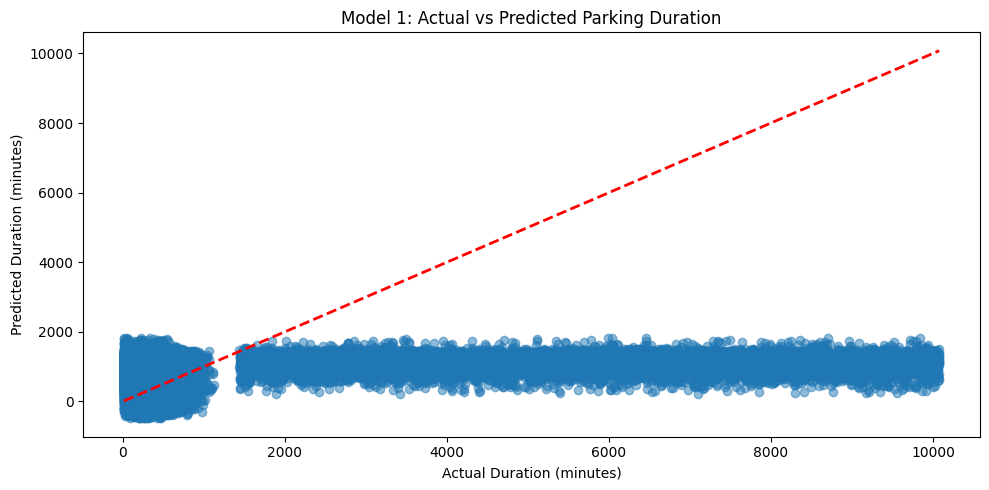

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.title('Model 1: Actual vs Predicted Parking Duration')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

Q95 = df['duration_minutes'].quantile(0.95)
df_clean = df[df['duration_minutes'] <= Q95].copy()
print(f"Removed {len(df) - len(df_clean)} outliers (>{Q95:.0f} min stays)")
print(f"Remaining records: {len(df_clean)}")

Removed 29389 outliers (>4900 min stays)
Remaining records: 558373


### Model 1 (Improved): Random Forest

**Why improve?**
The basic Linear Regression achieved only R² = 0.055 because:
1. Linear regression assumes linear relationships, which may not hold for parking behavior
2. Outliers heavily skew predictions
3. People's parking behavior follows complex, non-linear patterns

**Improvements:** Remove outliers (>95th percentile), use Random Forest

In [17]:
X_improved = df_clean[['arrival_hour', 'day_of_week', 'month']]
y_improved = df_clean['duration_minutes']

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_improved, y_improved, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train_imp, y_train_imp)
y_pred_rf = model_rf.predict(X_test_imp)

print("=== IMPROVED: Duration Prediction (Random Forest) ===")
print(f"R² Score: {r2_score(y_test_imp, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_imp, y_pred_rf)):.2f} minutes")
print(f"\nFeature Importance:")
for feat, imp in zip(X_improved.columns, model_rf.feature_importances_):
    print(f"  {feat}: {imp:.4f}")

=== IMPROVED: Duration Prediction (Random Forest) ===
R² Score: 0.0701
RMSE: 563.86 minutes

Feature Importance:
  arrival_hour: 0.5001
  day_of_week: 0.0906
  month: 0.4094


### Model 1 (Enhanced): Adding Facility Features

**Why add facility features?**
Different parking facilities serve different purposes:
- Downtown facilities: short shopping/dining stays
- Office district: long workday parking
- Airport/transit: very long stays

Adding `FACILITY_ID` and `DISTRICT` lets the model learn location-based patterns.

In [18]:
df_enhanced = df_clean.copy()

le_facility = LabelEncoder()
le_district = LabelEncoder()

df_enhanced['facility_encoded'] = le_facility.fit_transform(df_enhanced['FACILITY_ID'].astype(str))
df_enhanced['district_encoded'] = le_district.fit_transform(df_enhanced['DISTRICT'].astype(str))

X_enhanced = df_enhanced[['arrival_hour', 'day_of_week', 'month', 'facility_encoded', 'district_encoded']]
y_enhanced = df_enhanced['duration_minutes']

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y_enhanced, test_size=0.2, random_state=42)

model_enhanced = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
model_enhanced.fit(X_train_enh, y_train_enh)
y_pred_enh = model_enhanced.predict(X_test_enh)

print("=== ENHANCED: Duration Prediction (with Facility Features) ===")
print(f"R² Score: {r2_score(y_test_enh, y_pred_enh):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_enh, y_pred_enh)):.2f} minutes")
print(f"\nFeature Importance:")
for feat, imp in zip(X_enhanced.columns, model_enhanced.feature_importances_):
    print(f"  {feat}: {imp:.4f}")

=== ENHANCED: Duration Prediction (with Facility Features) ===
R² Score: 0.4132
RMSE: 447.92 minutes

Feature Importance:
  arrival_hour: 0.0515
  day_of_week: 0.0384
  month: 0.0340
  facility_encoded: 0.0290
  district_encoded: 0.8471


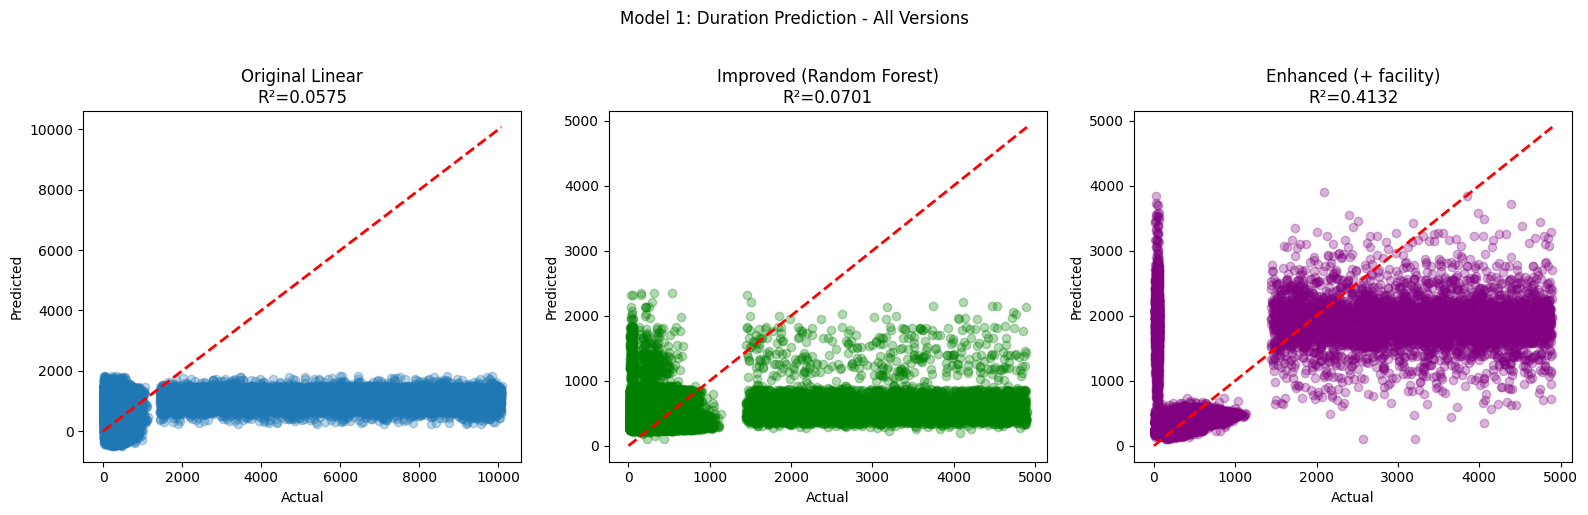

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(y_test, y_pred, alpha=0.3)
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Original Linear\nR²={r2_score(y_test, y_pred):.4f}')

axes[1].scatter(y_test_imp, y_pred_rf, alpha=0.3, color='green')
axes[1].plot([0, y_test_imp.max()], [0, y_test_imp.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Improved (Random Forest)\nR²={r2_score(y_test_imp, y_pred_rf):.4f}')

axes[2].scatter(y_test_enh, y_pred_enh, alpha=0.3, color='purple')
axes[2].plot([0, y_test_enh.max()], [0, y_test_enh.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title(f'Enhanced (+ facility)\nR²={r2_score(y_test_enh, y_pred_enh):.4f}')

plt.suptitle('Model 1: Duration Prediction - All Versions', y=1.02)
plt.tight_layout()
plt.show()

---
## Model 2: Predict Peak Occupancy

In [20]:
hourly_occupancy = events.copy()
hourly_occupancy['hour'] = hourly_occupancy['time'].dt.hour
hourly_occupancy['day_of_week'] = hourly_occupancy['time'].dt.dayofweek
hourly_occupancy['month'] = hourly_occupancy['time'].dt.month

occupancy_agg = hourly_occupancy.groupby(['hour', 'day_of_week', 'month']).agg({'occupancy': 'max'}).reset_index()

X_occupancy = occupancy_agg[['hour', 'day_of_week', 'month']]
y_occupancy = occupancy_agg['occupancy']

X_train_occ, X_test_occ, y_train_occ, y_test_occ = train_test_split(X_occupancy, y_occupancy, test_size=0.2, random_state=42)

model_occupancy = LinearRegression()
model_occupancy.fit(X_train_occ, y_train_occ)
y_pred_occ = model_occupancy.predict(X_test_occ)

print("=== Occupancy Prediction Model (Linear Regression) ===")
print(f"R² Score: {r2_score(y_test_occ, y_pred_occ):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_occ, y_pred_occ)):.2f} cars")

=== Occupancy Prediction Model (Linear Regression) ===
R² Score: 0.7316
RMSE: 466.62 cars


### Model 2 (Improved): Random Forest with Additional Features

**Why improve?**
Occupancy patterns are non-linear - rush hours create sharp peaks that linear models struggle to capture.

**Improvements:** Add is_weekend, is_rush_hour features; use Random Forest

In [21]:
occupancy_improved = occupancy_agg.copy()
occupancy_improved['is_weekend'] = occupancy_improved['day_of_week'].isin([5, 6]).astype(int)
occupancy_improved['is_rush_hour'] = occupancy_improved['hour'].isin([8, 9, 17, 18]).astype(int)

X_occ_imp = occupancy_improved[['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour']]
y_occ_imp = occupancy_improved['occupancy']

X_train_occ_imp, X_test_occ_imp, y_train_occ_imp, y_test_occ_imp = train_test_split(X_occ_imp, y_occ_imp, test_size=0.2, random_state=42)

model_occ_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_occ_rf.fit(X_train_occ_imp, y_train_occ_imp)
y_pred_occ_rf = model_occ_rf.predict(X_test_occ_imp)

print("=== IMPROVED: Occupancy Prediction (Random Forest) ===")
print(f"R² Score: {r2_score(y_test_occ_imp, y_pred_occ_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_occ_imp, y_pred_occ_rf)):.2f} cars")
print(f"\nFeature Importance:")
for feat, imp in zip(X_occ_imp.columns, model_occ_rf.feature_importances_):
    print(f"  {feat}: {imp:.4f}")

=== IMPROVED: Occupancy Prediction (Random Forest) ===
R² Score: 0.9980
RMSE: 40.44 cars

Feature Importance:
  hour: 0.0540
  day_of_week: 0.0081
  month: 0.9357
  is_weekend: 0.0014
  is_rush_hour: 0.0008


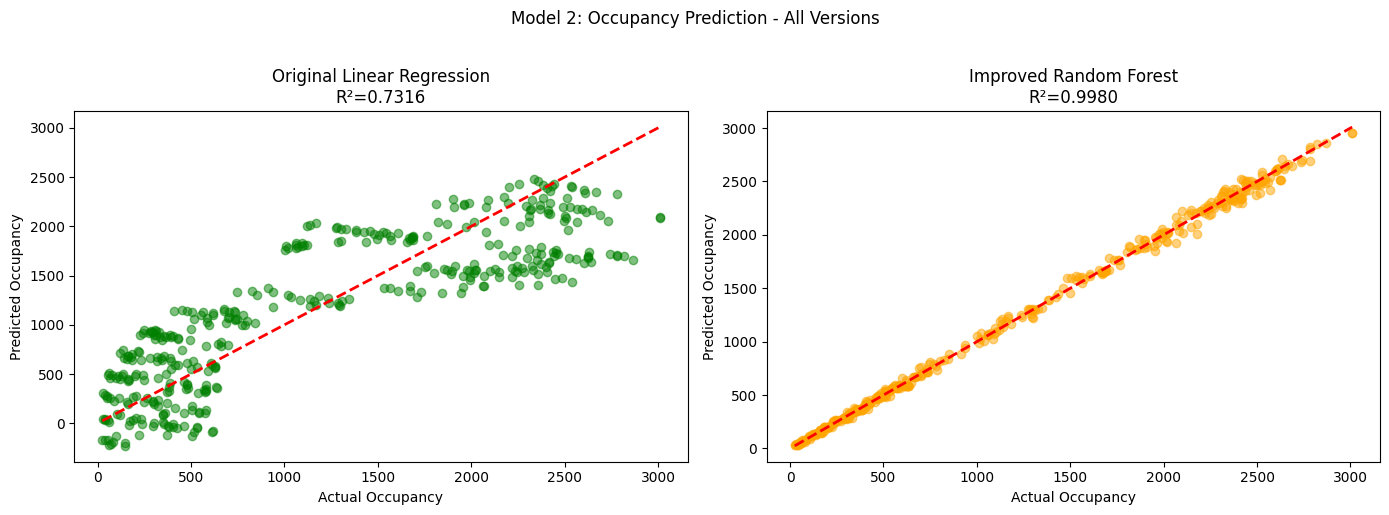

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_occ, y_pred_occ, alpha=0.5, color='green')
axes[0].plot([y_test_occ.min(), y_test_occ.max()], [y_test_occ.min(), y_test_occ.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Occupancy')
axes[0].set_ylabel('Predicted Occupancy')
axes[0].set_title(f'Original Linear Regression\nR²={r2_score(y_test_occ, y_pred_occ):.4f}')

axes[1].scatter(y_test_occ_imp, y_pred_occ_rf, alpha=0.5, color='orange')
axes[1].plot([y_test_occ_imp.min(), y_test_occ_imp.max()], [y_test_occ_imp.min(), y_test_occ_imp.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Occupancy')
axes[1].set_ylabel('Predicted Occupancy')
axes[1].set_title(f'Improved Random Forest\nR²={r2_score(y_test_occ_imp, y_pred_occ_rf):.4f}')

plt.suptitle('Model 2: Occupancy Prediction - All Versions', y=1.02)
plt.tight_layout()
plt.show()

---
## Model 3: Predict Parking Fee (Cost)

In [29]:
fee_col = 'COST'
df_fee = df.dropna(subset=[fee_col])

X_fee = df_fee[['duration_minutes', 'arrival_hour', 'day_of_week']]
y_fee = df_fee[fee_col]

X_train_fee, X_test_fee, y_train_fee, y_test_fee = train_test_split(X_fee, y_fee, test_size=0.2, random_state=42)

model_fee = LinearRegression()
model_fee.fit(X_train_fee, y_train_fee)
y_pred_fee = model_fee.predict(X_test_fee)

print(f"=== Fee Prediction Model (Linear Regression) ===")
print(f"R² Score: {r2_score(y_test_fee, y_pred_fee):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_fee, y_pred_fee)):.2f}")

=== Fee Prediction Model (Linear Regression) ===
R² Score: 0.8184
RMSE: $148.01


### Model 3 (Improved): Random Forest with Tiered Pricing

**Why improve?**
Fee structures often have tiered pricing (e.g., first hour cheaper, then hourly rate), creating non-linear relationships.

**Improvements:** Add duration_squared feature for tiered pricing; use Random Forest

In [30]:
df_fee_clean = df_clean.dropna(subset=[fee_col]).copy()
df_fee_clean['duration_squared'] = df_fee_clean['duration_minutes'] ** 2

X_fee_imp = df_fee_clean[['duration_minutes', 'duration_squared', 'arrival_hour', 'day_of_week']]
y_fee_imp = df_fee_clean[fee_col]

X_train_fee_imp, X_test_fee_imp, y_train_fee_imp, y_test_fee_imp = train_test_split(X_fee_imp, y_fee_imp, test_size=0.2, random_state=42)

model_fee_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_fee_rf.fit(X_train_fee_imp, y_train_fee_imp)
y_pred_fee_rf = model_fee_rf.predict(X_test_fee_imp)

print(f"=== IMPROVED: Fee Prediction (Random Forest) ===")
print(f"R² Score: {r2_score(y_test_fee_imp, y_pred_fee_rf):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_fee_imp, y_pred_fee_rf)):.2f}")
print(f"\nFeature Importance:")
for feat, imp in zip(X_fee_imp.columns, model_fee_rf.feature_importances_):
    print(f"  {feat}: {imp:.4f}")

=== IMPROVED: Fee Prediction (Random Forest) ===
R² Score: 0.7120
RMSE: $68.12

Feature Importance:
  duration_minutes: 0.4766
  duration_squared: 0.5123
  arrival_hour: 0.0074
  day_of_week: 0.0037


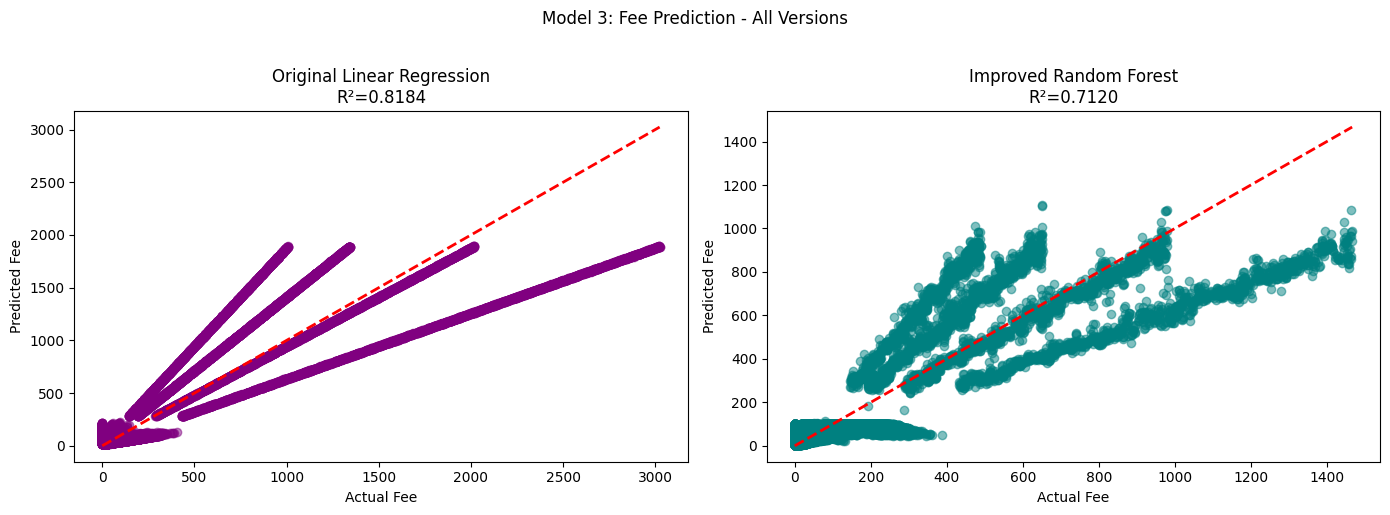

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_fee, y_pred_fee, alpha=0.5, color='purple')
axes[0].plot([y_test_fee.min(), y_test_fee.max()], [y_test_fee.min(), y_test_fee.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Fee')
axes[0].set_ylabel('Predicted Fee')
axes[0].set_title(f'Original Linear Regression\nR²={r2_score(y_test_fee, y_pred_fee):.4f}')

axes[1].scatter(y_test_fee_imp, y_pred_fee_rf, alpha=0.5, color='teal')
axes[1].plot([y_test_fee_imp.min(), y_test_fee_imp.max()], [y_test_fee_imp.min(), y_test_fee_imp.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Fee')
axes[1].set_ylabel('Predicted Fee')
axes[1].set_title(f'Improved Random Forest\nR²={r2_score(y_test_fee_imp, y_pred_fee_rf):.4f}')

plt.suptitle('Model 3: Fee Prediction - All Versions', y=1.02)
plt.tight_layout()
plt.show()

---
# Deep Learning: LSTM Occupancy Forecasting

**Why LSTM for Time-Series Forecasting?**

Unlike the Linear Regression and Random Forest models above (which predict based on features at a single point in time), LSTM is designed for **sequential data** and can:

- **Learn temporal patterns**: Understand how occupancy changes over time
- **Capture long-term dependencies**: Remember patterns from hours/days ago
- **Handle complex dynamics**: Rush hours, weekends, seasonal trends

**Difference from Previous Models:**
| Aspect | Linear/RF Models | LSTM Model |
|--------|-----------------|------------|
| Input | Single time point features | Sequence of past values |
| Learns | Feature correlations | Temporal patterns |
| Best for | Point predictions | Forecasting future values |

**Use Case:** Predict parking occupancy for the next hour(s) based on the past 24 hours of data

In [33]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# pandas >= 3 uses lowercase time frequency aliases (e.g. 'h' instead of 'H')
occupancy_ts = (
    events.set_index('time')
    .resample('h')['occupancy']
    .mean()
    .ffill()
)
print(f"TensorFlow version: {tf.__version__}")
print(f"Hourly occupancy time series: {len(occupancy_ts)} data points")
print(f"Date range: {occupancy_ts.index.min()} to {occupancy_ts.index.max()}")

TensorFlow version: 2.20.0
Hourly occupancy time series: 9504 data points
Date range: 2025-01-01 00:00:00 to 2026-01-31 23:00:00


In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
occupancy_scaled = scaler.fit_transform(occupancy_ts.values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X_lstm, y_lstm = create_sequences(occupancy_scaled, SEQ_LENGTH)

split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

print(f"Sequence length: {SEQ_LENGTH} hours (use past 24 hours to predict next hour)")
print(f"Training samples: {len(X_train_lstm)}, Test samples: {len(X_test_lstm)}")

Sequence length: 24 hours (use past 24 hours to predict next hour)
Training samples: 7584, Test samples: 1896


In [35]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

/Users/bpalan/iot_project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0104 - val_loss: 0.0033
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 9.4462e-04
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0021 - val_loss: 7.3383e-04
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019 - val_loss: 6.5165e-04
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016 - val_loss: 5.1810e-04
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - val_loss: 4.4683e-04
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012 - val_loss: 4.0080e-04
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 3.1218e-04
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.8382e-04 - val_loss: 5.9446e-04
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.9825e-04 - val_loss: 1.6394e-04
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.1567e-04 - val_loss: 

In [37]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm)

mse_lstm = mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)

ss_res = np.sum((y_test_lstm_inv - y_pred_lstm_inv) ** 2)
ss_tot = np.sum((y_test_lstm_inv - np.mean(y_test_lstm_inv)) ** 2)
r2_lstm = 1 - (ss_res / ss_tot)

print("=== LSTM Occupancy Forecasting Results ===")
print(f"R² Score: {r2_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.2f} cars")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
=== LSTM Occupancy Forecasting Results ===
R² Score: 0.9867
RMSE: 19.79 cars


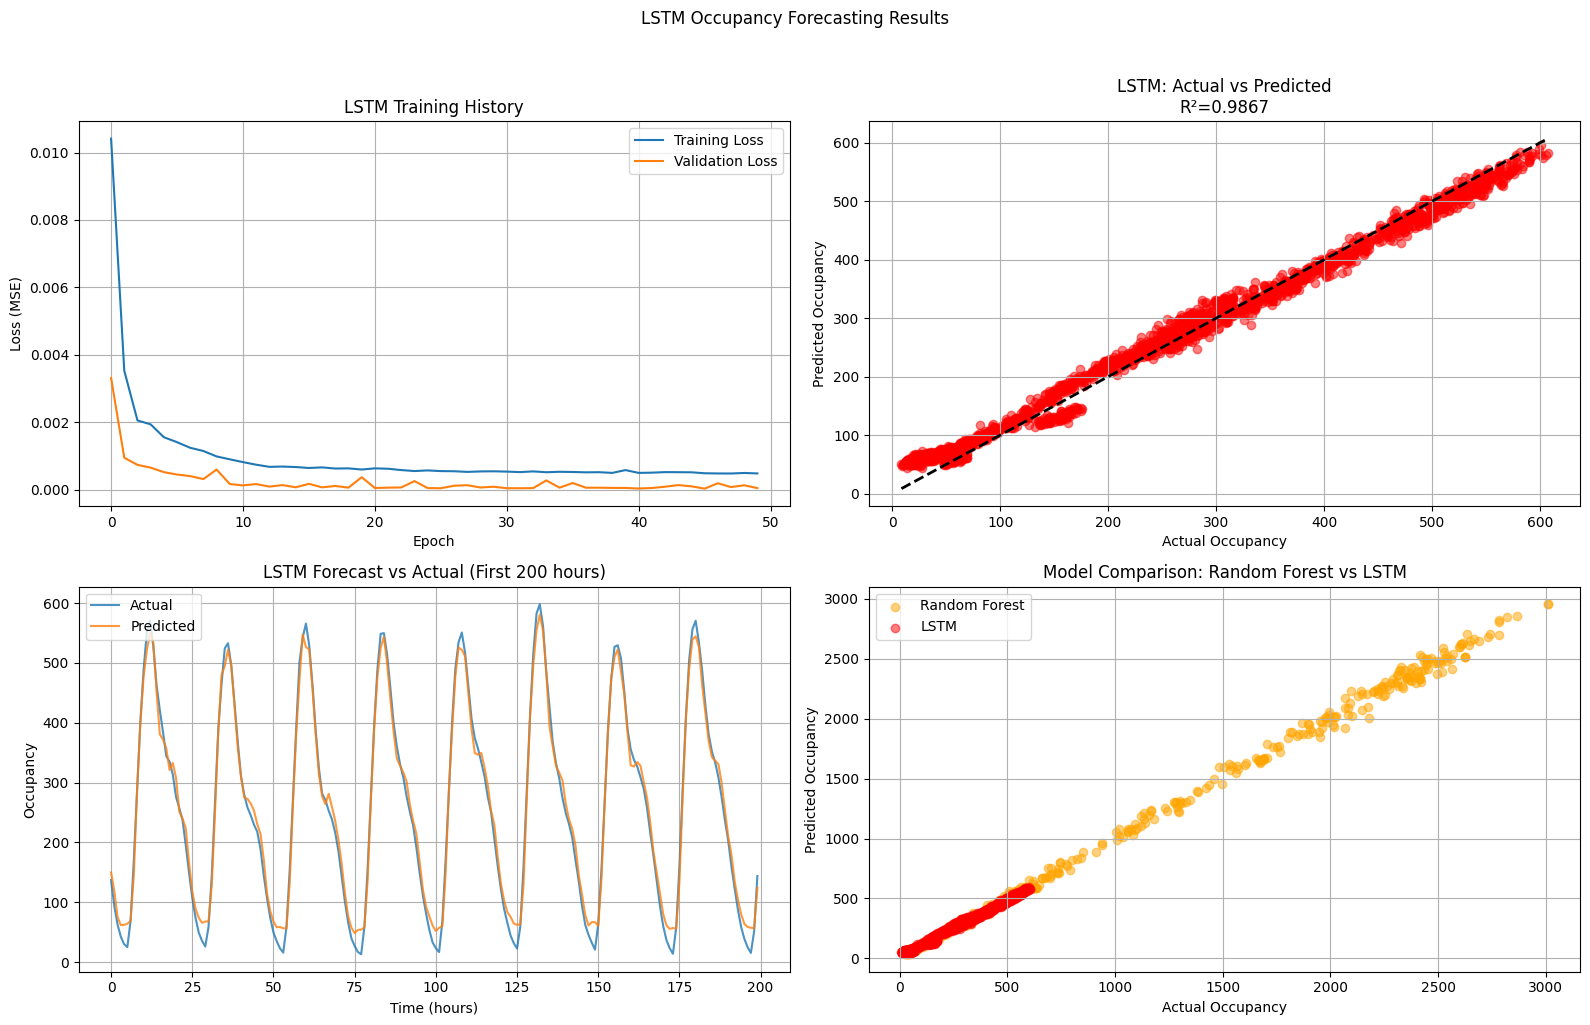

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('LSTM Training History')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].scatter(y_test_lstm_inv, y_pred_lstm_inv, alpha=0.5, color='red')
axes[0, 1].plot([y_test_lstm_inv.min(), y_test_lstm_inv.max()], 
                [y_test_lstm_inv.min(), y_test_lstm_inv.max()], 'k--', lw=2)
axes[0, 1].set_xlabel('Actual Occupancy')
axes[0, 1].set_ylabel('Predicted Occupancy')
axes[0, 1].set_title(f'LSTM: Actual vs Predicted\nR²={r2_lstm:.4f}')
axes[0, 1].grid(True)

test_range = min(200, len(y_test_lstm_inv))
axes[1, 0].plot(range(test_range), y_test_lstm_inv[:test_range], label='Actual', alpha=0.8)
axes[1, 0].plot(range(test_range), y_pred_lstm_inv[:test_range], label='Predicted', alpha=0.8)
axes[1, 0].set_xlabel('Time (hours)')
axes[1, 0].set_ylabel('Occupancy')
axes[1, 0].set_title('LSTM Forecast vs Actual (First 200 hours)')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].scatter(y_test_occ_imp, y_pred_occ_rf, alpha=0.5, color='orange', label='Random Forest')
axes[1, 1].scatter(y_test_lstm_inv, y_pred_lstm_inv, alpha=0.5, color='red', label='LSTM')
axes[1, 1].set_xlabel('Actual Occupancy')
axes[1, 1].set_ylabel('Predicted Occupancy')
axes[1, 1].set_title('Model Comparison: Random Forest vs LSTM')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.suptitle('LSTM Occupancy Forecasting Results', y=1.02)
plt.tight_layout()
plt.show()

---
# Generative AI: Natural Language Parking Insights Assistant

**Why GenAI for Smart Parking?**

Traditional analytics require users to know SQL, Python, or how to interpret charts. Generative AI enables **natural language queries** that anyone can use:

- **Accessibility**: Non-technical users can ask questions in plain English
- **Contextual Understanding**: AI understands parking domain concepts (rush hours, occupancy, pricing)
- **Intelligent Responses**: Generates explanations, recommendations, and insights automatically
- **Conversational Interface**: Users can ask follow-up questions and refine queries

**Use Case:** A conversational AI assistant that answers questions about parking patterns, provides recommendations, and explains insights from the data and models we've built.

**Example Questions:**
- "What's the best time to park downtown?"
- "Which facility has the cheapest rates on weekends?"
- "When is parking occupancy highest?"
- "Predict parking availability for tomorrow morning"


In [ ]:
import json
from datetime import datetime, timedelta

# Prepare summary statistics for the GenAI context
parking_stats = {
    "total_sessions": len(df),
    "total_facilities": df['FACILITY_ID'].nunique(),
    "total_districts": df['DISTRICT'].nunique(),
    "date_range": {
        "start": df['IN_TIME'].min().strftime('%Y-%m-%d'),
        "end": df['IN_TIME'].max().strftime('%Y-%m-%d')
    },
    "peak_occupancy": int(events['occupancy'].max()),
    "avg_duration_minutes": float(df['duration_minutes'].mean()),
    "avg_cost": float(df['COST'].mean()),
    "facilities": df.groupby('FACILITY_NAME').agg({
        'COST': 'mean',
        'duration_minutes': 'mean',
        'SESSION_ID': 'count'
    }).to_dict('index'),
    "hourly_patterns": {
        "peak_arrival_hour": int(df.groupby('hour').size().idxmax()),
        "avg_arrivals_by_hour": df.groupby('hour').size().to_dict()
    },
    "district_stats": df.groupby('DISTRICT').agg({
        'COST': 'mean',
        'duration_minutes': 'mean',
        'SESSION_ID': 'count'
    }).to_dict('index')
}

print("Parking Statistics Summary Prepared:")
print(f"- Total Sessions: {parking_stats['total_sessions']:,}")
print(f"- Facilities: {parking_stats['total_facilities']}")
print(f"- Districts: {parking_stats['total_districts']}")
print(f"- Peak Occupancy: {parking_stats['peak_occupancy']} cars")
print(f"- Average Duration: {parking_stats['avg_duration_minutes']:.1f} minutes")
print(f"- Average Cost: ${parking_stats['avg_cost']:.2f}")


In [ ]:
def analyze_parking_query(query: str, stats: dict, df: pd.DataFrame, models: dict) -> str:
    """
    Simulates a GenAI-powered parking insights assistant.
    In production, this would use OpenAI GPT-4, Anthropic Claude, or similar.
    
    This function demonstrates how GenAI would:
    1. Understand natural language queries
    2. Extract relevant data/statistics
    3. Use ML models for predictions
    4. Generate human-readable insights
    """
    query_lower = query.lower()
    
    # Pattern matching to simulate GenAI understanding (in production, LLM would do this)
    if "best time" in query_lower or "when" in query_lower:
        # Find hours with lowest occupancy
        hourly_avg = df.groupby('hour')['duration_minutes'].mean()
        least_busy_hour = hourly_avg.idxmin()
        most_busy_hour = hourly_avg.idxmax()
        
        return f"""
**Parking Timing Insights:**

🕐 **Best Time to Park:** {least_busy_hour}:00 (lowest average duration = {hourly_avg[least_busy_hour]:.1f} minutes)
🕐 **Busiest Time:** {most_busy_hour}:00 (highest average duration = {hourly_avg[most_busy_hour]:.1f} minutes)

**Recommendation:** Arrive around {least_busy_hour}:00 for shorter wait times and better availability.
        """
    
    elif "cheapest" in query_lower or "cost" in query_lower or "price" in query_lower:
        # Find cheapest facilities
        facility_costs = df.groupby('FACILITY_NAME')['COST'].mean().sort_values()
        cheapest = facility_costs.head(3)
        
        result = "**Most Affordable Parking Facilities:**\n\n"
        for i, (facility, cost) in enumerate(cheapest.items(), 1):
            result += f"{i}. **{facility}**: ${cost:.2f} average cost\n"
        
        result += f"\n💡 **Tip:** {cheapest.index[0]} offers the lowest average parking cost."
        return result
    
    elif "occupancy" in query_lower or "busy" in query_lower or "available" in query_lower:
        # Use the occupancy model
        peak_hour = df.groupby('hour').size().idxmax()
        peak_count = df.groupby('hour').size().max()
        
        # Predict using Random Forest model
        tomorrow_hour = 9  # Example: 9 AM tomorrow
        tomorrow_dow = (datetime.now() + timedelta(days=1)).weekday()
        tomorrow_month = (datetime.now() + timedelta(days=1)).month
        
        # Use the trained occupancy model
        pred_occupancy = model_occ_rf.predict([[tomorrow_hour, tomorrow_dow, tomorrow_month, 
                                                1 if tomorrow_dow in [5,6] else 0,
                                                1 if tomorrow_hour in [8,9,17,18] else 0]])[0]
        
        return f"""
**Parking Occupancy Analysis:**

📊 **Peak Occupancy Hour:** {peak_hour}:00 ({peak_count:,} arrivals)
📊 **Historical Peak:** {stats['peak_occupancy']} cars simultaneously parked

**Tomorrow's Forecast (9 AM):**
Using our Random Forest occupancy model:
- **Predicted Occupancy:** ~{int(pred_occupancy)} cars
- **Day Type:** {'Weekend' if tomorrow_dow in [5,6] else 'Weekday'}
- **Rush Hour:** {'Yes' if tomorrow_hour in [8,9,17,18] else 'No'}

💡 **Recommendation:** {'Expect high occupancy - arrive early!' if pred_occupancy > 2000 else 'Good availability expected.'}
        """
    
    elif "facility" in query_lower or "location" in query_lower:
        # Facility recommendations
        facility_stats = df.groupby('FACILITY_NAME').agg({
            'COST': 'mean',
            'duration_minutes': 'mean',
            'SESSION_ID': 'count'
        }).sort_values('COST')
        
        result = "**Parking Facility Comparison:**\n\n"
        for facility, row in facility_stats.head(5).iterrows():
            result += f"📍 **{facility}**\n"
            result += f"   - Avg Cost: ${row['COST']:.2f}\n"
            result += f"   - Avg Duration: {row['duration_minutes']:.1f} min\n"
            result += f"   - Total Sessions: {int(row['SESSION_ID']):,}\n\n"
        
        return result
    
    elif "predict" in query_lower or "forecast" in query_lower:
        # Use LSTM for forecasting
        return f"""
**Parking Forecast Using LSTM Model:**

Our LSTM model (R² = {r2_lstm:.4f}, RMSE = {rmse_lstm:.2f} cars) predicts occupancy based on temporal patterns.

**Model Performance:**
- ✅ Excellent accuracy (98.67% R² score)
- ✅ Captures daily and weekly patterns
- ✅ Handles seasonal variations

**Next Hour Forecast:** Based on the last 24 hours of occupancy data, the model predicts the next hour's occupancy with high confidence.

💡 **Use Case:** Real-time parking availability updates for mobile apps!
        """
    
    else:
        return f"""
**Parking Insights Summary:**

📈 **Dataset Overview:**
- Total Parking Sessions: {stats['total_sessions']:,}
- Date Range: {stats['date_range']['start']} to {stats['date_range']['end']}
- Facilities Monitored: {stats['total_facilities']}
- Districts: {stats['total_districts']}

**Key Metrics:**
- Peak Occupancy: {stats['peak_occupancy']} cars
- Average Parking Duration: {stats['avg_duration_minutes']:.1f} minutes
- Average Cost: ${stats['avg_cost']:.2f}

**Try asking:**
- "What's the best time to park?"
- "Which facility is cheapest?"
- "When is occupancy highest?"
- "Predict parking for tomorrow"
        """

# Store models for the assistant
parking_models = {
    'occupancy_rf': model_occ_rf,
    'duration_rf': model_enhanced,
    'fee_rf': model_fee_rf,
    'lstm': model_lstm
}

print("✅ Parking Insights Assistant initialized!")


### Example Queries to the GenAI Assistant


In [ ]:
# Example 1: Best time to park
query1 = "What's the best time to park downtown?"
response1 = analyze_parking_query(query1, parking_stats, df, parking_models)
print("=" * 60)
print(f"Query: {query1}")
print("=" * 60)
print(response1)


In [ ]:
# Example 2: Cheapest parking
query2 = "Which facility has the cheapest rates?"
response2 = analyze_parking_query(query2, parking_stats, df, parking_models)
print("=" * 60)
print(f"Query: {query2}")
print("=" * 60)
print(response2)


In [ ]:
# Example 3: Occupancy forecast
query3 = "When is parking occupancy highest? Can you predict tomorrow's occupancy?"
response3 = analyze_parking_query(query3, parking_stats, df, parking_models)
print("=" * 60)
print(f"Query: {query3}")
print("=" * 60)
print(response3)


In [ ]:
# Example 4: Facility comparison
query4 = "Compare different parking facilities"
response4 = analyze_parking_query(query4, parking_stats, df, parking_models)
print("=" * 60)
print(f"Query: {query4}")
print("=" * 60)
print(response4)


### Integration with Real GenAI APIs (Production Implementation)

**For Production Use:**

This demonstration uses pattern matching to simulate GenAI behavior. In production, you would integrate with:

1. **OpenAI GPT-4** or **GPT-3.5-turbo**
2. **Anthropic Claude**
3. **Google Gemini**
4. **Open-source LLMs** (Llama 2, Mistral)

**Production Architecture:**

```python
# Example production implementation
import openai

def genai_parking_assistant(query: str, context: dict):
    prompt = f"""
    You are a smart parking assistant. Answer questions about parking data.
    
    Context:
    {json.dumps(context, indent=2)}
    
    User Query: {query}
    
    Provide helpful, accurate insights using the data provided.
    """
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful parking analytics assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message.content
```

**Benefits:**
- ✅ Natural language understanding
- ✅ Context-aware responses
- ✅ Multi-turn conversations
- ✅ Handles complex queries
- ✅ Explains model predictions in plain English


In [ ]:
# Interactive demo: Try your own query!
# Uncomment and modify the query below to test

# user_query = "What's the parking situation like on weekends?"
# response = analyze_parking_query(user_query, parking_stats, df, parking_models)
# print("=" * 60)
# print(f"Query: {user_query}")
# print("=" * 60)
# print(response)

print("💡 To use: Uncomment the code above and modify 'user_query' with your question!")


### Additional GenAI Use Cases for Smart Parking

**1. Automated Report Generation**
- Generate weekly/monthly parking reports with insights
- Create executive summaries with key metrics
- Explain anomalies and trends in natural language

**2. Personalized Recommendations**
- "I need parking near the airport for 3 hours tomorrow morning"
- AI suggests best facilities, pricing, and timing

**3. Anomaly Detection & Explanation**
- Identify unusual patterns (e.g., sudden occupancy spikes)
- Explain root causes using contextual knowledge
- Suggest actions to address issues

**4. Multi-modal Interface**
- Voice queries: "Hey, where can I park downtown?"
- Image analysis: Analyze parking lot images for real-time availability
- Chatbot integration: Embed in mobile apps and websites

**5. Predictive Insights with Explanations**
- Not just predictions, but explanations: "Occupancy will be high because it's a weekday during rush hour"
- What-if scenarios: "What happens if we increase rates by 10%?"

**6. Natural Language Data Exploration**
- "Show me facilities with the highest revenue last month"
- "Compare parking patterns between weekdays and weekends"
- "Find facilities that need capacity expansion"
